# Import Library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx, subgraph, k_hop_subgraph
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import random

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load Cora Dataset

In [4]:
dataset = Planetoid(root="../data/Cora", name="Cora")
data = dataset[0]

In [5]:
node_of_interest = random.randint(0, data.num_nodes - 1)
print("Node of Interest:", node_of_interest)

# extract 2-hop subgraph
subset_nodes, sub_edge_index, _, _ = k_hop_subgraph(
    node_of_interest, 
    num_hops=2, 
    edge_index=data.edge_index, 
    relabel_nodes=True
)

sub_x = data.x[subset_nodes]
sub_y = data.y[subset_nodes]

print("Subgraph Nodes:", sub_x.size(0))

Node of Interest: 2619
Subgraph Nodes: 2


In [6]:
#Jumlah Node
data.num_nodes

2708

In [7]:
#jumlah edge
data.num_edges

10556

In [8]:
#dimensi fitur
data.num_features

1433

In [9]:
#jumlah keasl
dataset.num_classes

7

In [10]:
#nama kelas
data.y.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [11]:
#nodes belong to classes
data.y.bincount()

tensor([351, 217, 418, 818, 426, 298, 180])

In [12]:
class_counts = data.y.bincount()
for class_idx in range(len(class_counts)):
    print(f"Kelas {class_idx}: {class_counts[class_idx].item()} nodes")

Kelas 0: 351 nodes
Kelas 1: 217 nodes
Kelas 2: 418 nodes
Kelas 3: 818 nodes
Kelas 4: 426 nodes
Kelas 5: 298 nodes
Kelas 6: 180 nodes


In [13]:
#train nodes
data.train_mask.sum().item()

140

In [14]:
print(f"\nTrain ratio: {data.train_mask.sum().item()/data.num_nodes:.2%}")


Train ratio: 5.17%


In [15]:
#validation nodes
data.val_mask.sum().item()

500

In [16]:
print(f"Validation ratio: {data.val_mask.sum().item()/data.num_nodes:.2%}")

Validation ratio: 18.46%


In [17]:
#test nodes
data.test_mask.sum().item()

1000

In [18]:
print(f"Test ratio: {data.test_mask.sum().item()/data.num_nodes:.2%}")

Test ratio: 36.93%


In [19]:
data.edge_index.shape

torch.Size([2, 10556])

In [ ]:
data.edge_index[:, :5]

tensor([[ 633, 1862, 2582,    2,  652],
        [   0,    0,    0,    1,    1]])

 Artinya: node 633 cite node 0, node 1862 cite node 0, dll

In [21]:
data.x[0, :10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Output: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Features adalah sparse (banyak zeros = bag-of-words)

# SAMPLING & SUBGRAPH EXTRACTION (2-3 HOPS)

In [ ]:
# Pilih random node sebagai pusat
node_of_interest = random.randint(0, data.num_nodes - 1)

In [23]:
print(f"Node of Interest: {node_of_interest} (Class: {data.y[node_of_interest].item()})")

Node of Interest: 456 (Class: 0)


In [ ]:
# Extract 2-hop neighborhood (bisa ganti 3 untuk 3-hop)
# k_hop_subgraph = ambil semua nodes dalam k-hop dari node awal
subset_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
    node_of_interest,           # Node pusat
    num_hops=2,                 # Ambil neighbor sampai 2 hop away
    edge_index=data.edge_index, # Gunakan edge index dari full graph
    relabel_nodes=True,         # Renumber nodes 0 to N dalam subgraph
    num_nodes=data.num_nodes    # Total nodes di full graph
)

# Extract features dan labels untuk subgraph nodes
sub_x = data.x[subset_nodes]           # Feature untuk subgraph
sub_y = data.y[subset_nodes]           # Label untuk subgraph
sub_train_mask = data.train_mask[subset_nodes]  # Train mask untuk subgraph
sub_val_mask = data.val_mask[subset_nodes]      # Val mask untuk subgraph

print(f"Subgraph Nodes: {sub_x.size(0)}")        # Berapa nodes dalam subgraph
print(f"Subgraph Edges: {sub_edge_index.size(1)}")  # Berapa edges
print(f"Classes in Subgraph: {torch.unique(sub_y).tolist()}")  # Classes apa saja

Subgraph Nodes: 55
Subgraph Edges: 216
Classes in Subgraph: [0, 1, 3]


# VISUALIZE SUBGRAPH

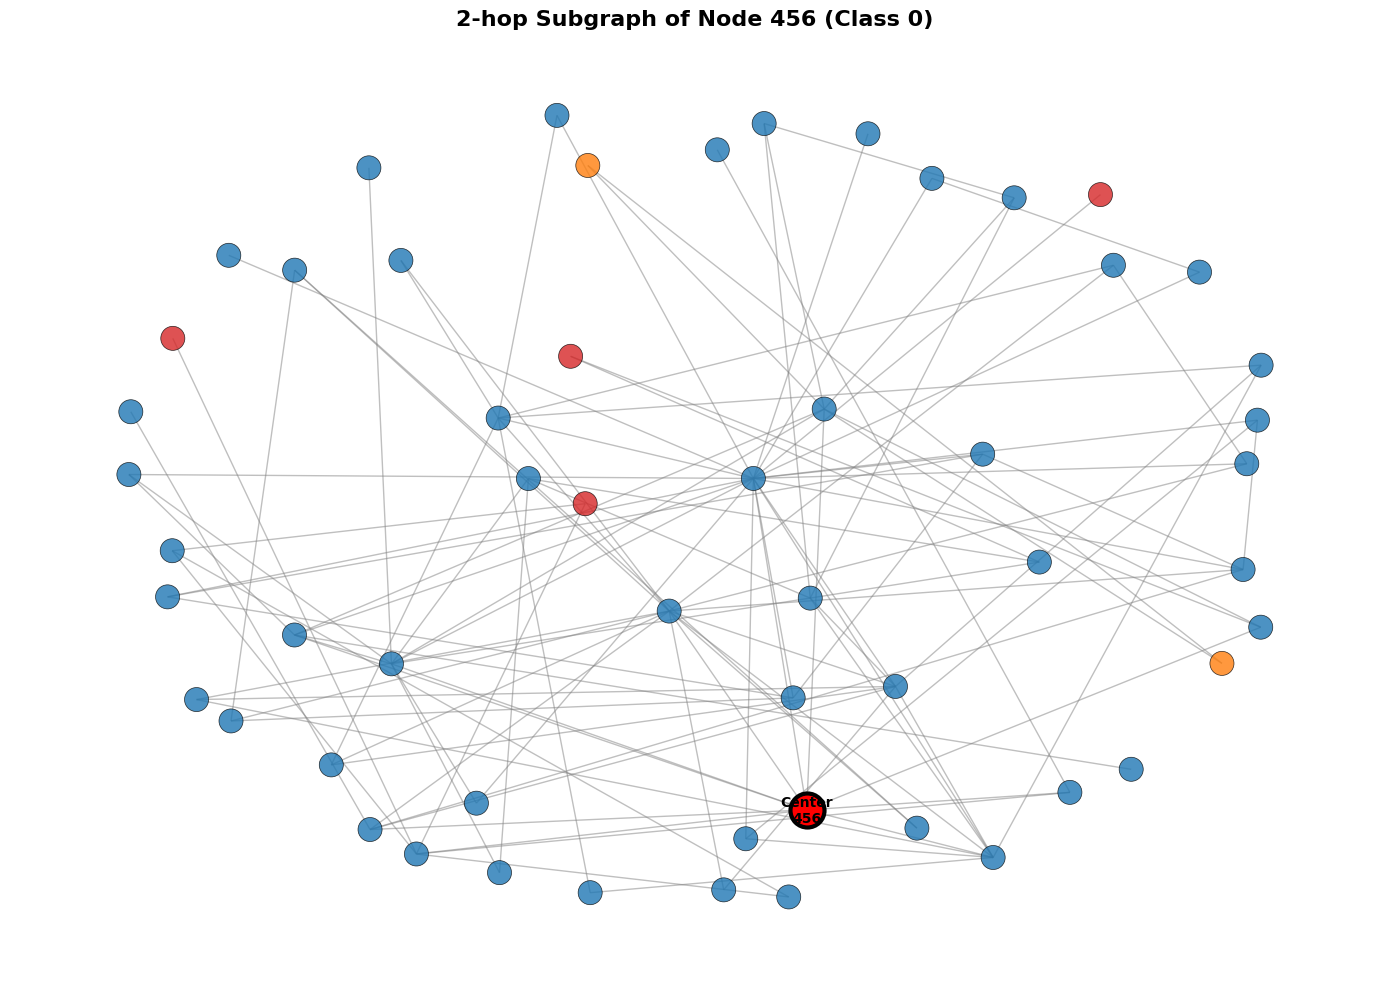

In [ ]:
# ===== VISUALISASI SUBGRAPH SEBAGAI NETWORK GRAPH =====

# Convert torch graph ke NetworkX format untuk visualisasi
subgraph_data = Data(x=sub_x, edge_index=sub_edge_index)  # Create Data object
G = to_networkx(subgraph_data, to_undirected=True)        # Convert ke NetworkX graph

# Buat figure besar
plt.figure(figsize=(14, 10))

# Setup warna berdasarkan class label
cmap = plt.cm.tab10  # Color map dengan 10 warna berbeda
node_colors = [cmap(y) for y in sub_y.numpy()]  # Assign warna per node

# Hitung posisi nodes menggunakan spring layout
pos = nx.spring_layout(G, seed=42, k=1. 5)  # k=1.5: spacing antar nodes

# Cari index node pusat dalam subgraph (bukan ID original)
center_idx = (subset_nodes == node_of_interest).nonzero(as_tuple=True)[0].item()

# Draw semua nodes dengan warna berdasarkan class
nx.draw_networkx_nodes(
    G, pos, 
    node_size=300,           # Ukuran node
    node_color=node_colors,  # Warna berdasarkan class
    alpha=0.8,               # Transparency
    linewidths=0.5,
    edgecolors='black'
)

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray')

# Highlight node pusat dengan warna merah dan ukuran lebih besar
nx.draw_networkx_nodes(
    G, pos, 
    nodelist=[center_idx],  # Hanya highlight center node
    node_size=600,
    node_color='red',
    edgecolors='black',
    linewidths=3
)

# Tambah label untuk center node
labels = {center_idx: f'Center\n{node_of_interest}'}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')

# Title dan cleanup
plt.title(f"2-hop Subgraph of Node {node_of_interest} (Class {data.y[node_of_interest]. item()})", 
          fontsize=16, fontweight='bold')
plt.axis('off')  # Hide axis
plt.tight_layout()
plt.show()

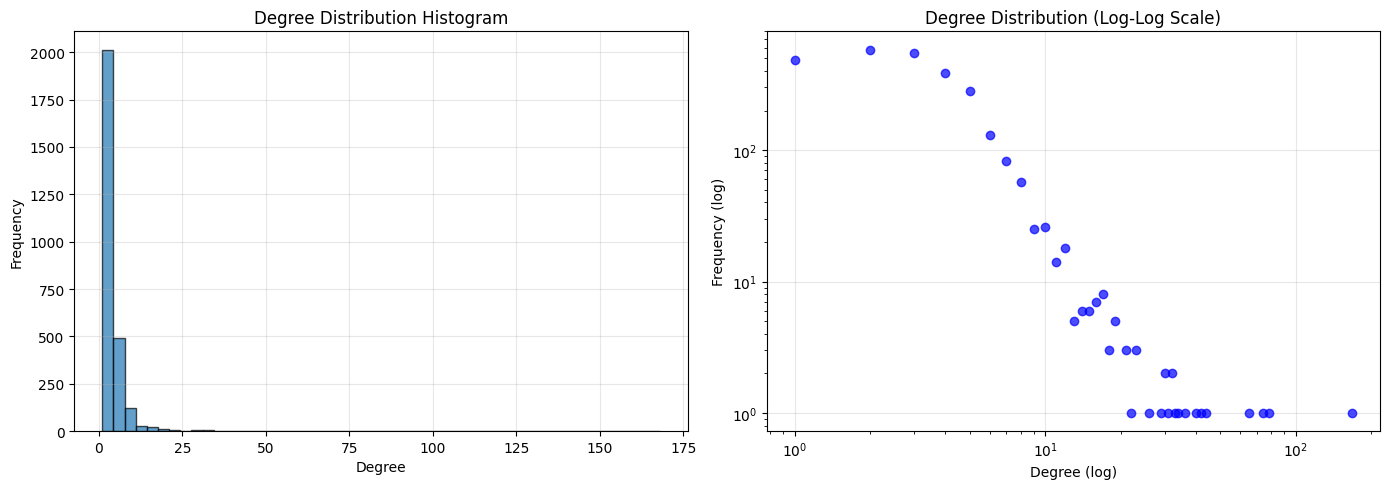

In [26]:
degrees = np.zeros(data.num_nodes)
for i in range(data.num_nodes):
    degrees[i] = (data.edge_index[0] == i).sum().item()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of degree distribution
axes[0].hist(degrees, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Degree Distribution Histogram')
axes[0].grid(True, alpha=0.3)

# Log-log plot for power law check
unique_degrees, degree_counts = np.unique(degrees, return_counts=True)
axes[1].loglog(unique_degrees, degree_counts, 'bo', alpha=0.7)
axes[1].set_xlabel('Degree (log)')
axes[1].set_ylabel('Frequency (log)')
axes[1].set_title('Degree Distribution (Log-Log Scale)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
print(f"• Average degree: {degrees.mean():.2f}")
print(f"• Maximum degree: {degrees.max():.0f}")
print(f"• Minimum degree: {degrees.min():.0f}")

• Average degree: 3.90
• Maximum degree: 168
• Minimum degree: 1


# PRA-PROSES (Message Passing Layer)

$h_u^{(k)} = \sum W_{\text{msg}} \cdot h_u^{(k-1)} + W_{\text{self}} \cdot h_v^{(k-1)}$

 di mana,
 1. **k** adalah urutan lapisan GNN.
 2. **Wmsg** adalah bobot yang diakses bersama dengan neighborhood nodes.
 3. **Wself** adalah bobot milik node asal (v).

In [ ]:
# ===== CUSTOM MESSAGE PASSING LAYER =====
# Implement custom message passing dengan separate weights untuk neighbor vs self

class CustomMessagePassing(MessagePassing):
    """
    Custom message passing dengan formula: 
    h_v^(k) = sum(W_msg * h_neighbor) + W_self * h_v
    
    Ini lebih interpretable daripada standard GNN aggregation
    """
    
    def __init__(self, in_channels, out_channels):
        # in_channels: dimensi input features
        # out_channels: dimensi output features
        super().__init__(aggr='add')  # Aggregate neighbor messages via sum (permutation invariant)
        
        # Weight untuk transform neighbor features
        self.W_msg = nn.Linear(in_channels, out_channels, bias=False)
        
        # Weight untuk transform self node features
        self.W_self = nn.Linear(in_channels, out_channels, bias=False)
        
    def forward(self, x, edge_index):
        # x: node features [num_nodes, in_channels]
        # edge_index: edge connections [2, num_edges]
        # 
        # propagate() = call message() untuk setiap edge, aggregate, call update()
        return self.propagate(edge_index, x=x)
    
    def message(self, x_j):
        # x_j: features dari neighbor nodes (source dalam edge_index)
        # Return: transformed neighbor features
        return self.W_msg(x_j)
    
    def update(self, aggr_out, x):
        # aggr_out:  aggregated (summed) neighbor messages
        # x: self node features (target dalam edge_index)
        # Combine neighbor info dengan self info
        return aggr_out + self.W_self(x)

In [29]:
# # TEST MESSAGE PASSING

# test_mp = CustomMessagePassing(in_channels=16, out_channels=32)
# test_mp

In [30]:
# test_mp.W_msg.weight.shape

In [31]:
# test_mp.W_self.weight.shape

# Intra-layer GNN Block

$$
\mathbf{h}_v^{(k)} =
\text{ACT}\!\left(
    \text{Dropout}\!\left(
        \text{BatchNorm}\!\left(
            \mathbf{W}^{(k-1)}\,\mathbf{h}_v^{(k-1)} + \mathbf{b}^{(k-1)}
        \right)
    \right)
\right)
+ \mathbf{h}_v^{(k-1)}
$$


di mana:

1. **ACT** adalah fungsi aktivasi yang Anda pilih.
2. **BatchNorm** adalah `1D-Batch Normalization`.


## DEFINE SINGLE GNN LAYER 

In [ ]:
# ===== DEFINE SINGLE GNN LAYER =====
# Setiap layer melakukan:  message passing → post-processing → residual connection

class GNNLayer(nn.Module):
    """
    Single GNN layer dengan:
    1. Message passing
    2. Linear transformation
    3. Batch normalization (stabilisasi)
    4. Dropout (regularisasi)
    5. ReLU activation (non-linearity)
    6.  Residual connection (gradient flow)
    """
    
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super().__init__()
        
        # ===== CORE:  MESSAGE PASSING =====
        # Aggregasi informasi dari neighbors dan self
        self.message_passing = CustomMessagePassing(in_channels, out_channels)
        
        # ===== POST-PROCESSING COMPONENTS =====
        # Linear transformation untuk feature refinement
        self.linear = nn.Linear(out_channels, out_channels)
        
        # Batch Normalization 1D
        # - Normalize activations:  (x - mean) / std
        # - Stabilisasi training, reduce internal covariate shift
        # - Memungkinkan higher learning rates
        self.batch_norm = nn.BatchNorm1d(out_channels)
        
        # Dropout:  randomly zero 50% activations
        # - Regularisasi:  prevent overfitting
        # - Force network learn redundant representations
        self.dropout = nn. Dropout(dropout)
        
        # ReLU activation function
        # - Non-linearity:  max(0, x)
        # - Allow network learn complex patterns
        self.activation = nn.ReLU()
        
        # ===== RESIDUAL CONNECTION =====
        # Skip connection untuk mengatasi vanishing gradient di deep networks
        if in_channels != out_channels: 
            # Jika dimensi berbeda, project input ke output dimensi
            self.residual = nn.Linear(in_channels, out_channels)
        else:
            # Jika dimensi sama, just pass through (identity)
            self.residual = nn.Identity()
    
    def forward(self, x, edge_index):
        """
        Forward pass:
        Input → Message Passing → Linear → BatchNorm → Dropout → ReLU → + Residual
        """
        
        # Save original input untuk residual connection
        x_input = x
        
        # ===== STEP 1: MESSAGE PASSING =====
        # Combine neighbor dan self information
        x = self.message_passing(x, edge_index)  # [N, out_channels]
        
        # ===== STEP 2: LINEAR TRANSFORMATION =====
        # Additional feature transformation
        x = self.linear(x)
        
        # ===== STEP 3: BATCH NORMALIZATION =====
        # Normalize features untuk stable training
        x = self.batch_norm(x)
        
        # ===== STEP 4: DROPOUT =====
        # Regularisasi untuk prevent overfitting
        x = self.dropout(x)
        
        # ===== STEP 5: ACTIVATION =====
        # Non-linearity
        x = self.activation(x)
        
        # ===== STEP 6: RESIDUAL CONNECTION =====
        # Add original input (with dimension projection jika perlu)
        x = x + self.residual(x_input)
        
        return x

## Test GNN Layer

In [33]:
# test_layer = GNNLayer(in_channels=16, out_channels=32)
# test_layer

In [34]:
# test_layer.batch_norm

In [35]:
# test_layer.dropout.p

In [36]:
# test_layer.activation

# Full Model with k>1 Layers

In [ ]:
# ===== FULL MODEL:  STACK MULTIPLE GNN LAYERS =====
# Create deep GNN dengan multiple layers untuk capture k-hop neighborhood

class GNNModel(nn.Module):
    """
    Multi-layer Graph Neural Network: 
    Input Features → Input Projection → [GNN Layer 1-k] → Output Layer → Classifier
    
    Parameters:
    - in_channels: dimensi input features (1433 untuk Cora)
    - hidden_channels: dimensi internal representations (128)
    - out_channels: dimensi sebelum classifier (64)
    - num_classes: jumlah classes (7 untuk Cora)
    - num_layers: berapa banyak GNN layers (k)
    - dropout: dropout rate (0.6)
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, num_classes, 
                 num_layers=3, dropout=0.5):
        super().__init__()
        
        # Validasi num_layers
        assert num_layers > 1, "num_layers must be > 1"
        
        # ===== INPUT PROJECTION =====
        # Project sparse features (1433-dim) ke dense (128-dim)
        # Dense features lebih efisien untuk computation
        self.input_proj = nn.Linear(in_channels, hidden_channels)
        
        # ===== STACK GNN LAYERS =====
        # Create list of GNN layers (k > 1)
        # Each layer:  maintain hidden_channels dimensi
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            # All layers:  hidden → hidden channels
            # (bisa customize untuk different dimensi per layer)
            self.layers. append(
                GNNLayer(hidden_channels, hidden_channels, dropout)
            )
        
        # ===== OUTPUT LAYER =====
        # Project dari hidden_channels ke out_channels
        self.output_layer = nn.Linear(hidden_channels, out_channels)
        
        # ===== CLASSIFIER =====
        # Final layer:  predict class logits
        # out_channels → num_classes
        self.classifier = nn.Linear(out_channels, num_classes)
    
    def forward(self, x, edge_index):
        """
        Forward pass through entire model
        
        x: [num_nodes, in_channels] = node features
        edge_index: [2, num_edges] = edge connections
        
        Output: [num_nodes, num_classes] = log probabilities untuk setiap class
        """
        
        # ===== STEP 1: INPUT PROJECTION =====
        # Sparse features → Dense features
        x = self.input_proj(x)  # [N, 1433] → [N, 128]
        x = F.relu(x)           # Non-linearity
        
        # ===== STEP 2: PASS THROUGH GNN LAYERS =====
        # k-layer message passing
        # Each layer aggregates information dari neighbors
        for layer in self.layers:
            x = layer(x, edge_index)  # Message passing + post-processing
        
        # ===== STEP 3: OUTPUT LAYER =====
        # Project ke output dimensi
        x = self.output_layer(x)  # [N, 128] → [N, 64]
        x = F.relu(x)
        
        # ===== STEP 4: CLASSIFIER =====
        # Project ke class logits
        x = self.classifier(x)  # [N, 64] → [N, 7]
        
        # ===== STEP 5: LOG-SOFTMAX =====
        # Convert logits to log-probabilities
        # dim=1: softmax across class dimension
        return F.log_softmax(x, dim=1)  # [N, 7] log-probabilities

# Model Structure

In [ ]:
# ===== CREATE MODEL INSTANCE =====

# Create GNN model dengan konfigurasi: 
model = GNNModel(
    in_channels=data.num_features,      # 1433 (Cora features)
    hidden_channels=128,                 # Internal representation dimensi
    out_channels=64,                     # Before classifier dimensi
    num_classes=dataset.num_classes,     # 7 (Cora classes)
    num_layers=3,                        # 3 GNN layers (k=3)
    dropout=0.6                          # 60% dropout untuk regularisasi
)



In [39]:
model

GNNModel(
  (input_proj): Linear(in_features=1433, out_features=128, bias=True)
  (layers): ModuleList(
    (0-2): 3 x GNNLayer(
      (message_passing): CustomMessagePassing()
      (linear): Linear(in_features=128, out_features=128, bias=True)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.6, inplace=False)
      (activation): ReLU()
      (residual): Identity()
    )
  )
  (output_layer): Linear(in_features=128, out_features=64, bias=True)
  (classifier): Linear(in_features=64, out_features=7, bias=True)
)

In [ ]:
# Hitung total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")  # ~340K



In [41]:
total_params

340871

In [ ]:
# Hitung trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters: {trainable_params}")  # ~340K (semuanya trainable)

In [43]:
trainable_params

340871

In [44]:
for name, param in model.named_parameters():
    print(f"{name:50s} | Shape: {str(list(param.shape)):20s} | Params: {param.numel():,}")

input_proj.weight                                  | Shape: [128, 1433]          | Params: 183,424
input_proj.bias                                    | Shape: [128]                | Params: 128
layers.0.message_passing.W_msg.weight              | Shape: [128, 128]           | Params: 16,384
layers.0.message_passing.W_self.weight             | Shape: [128, 128]           | Params: 16,384
layers.0.linear.weight                             | Shape: [128, 128]           | Params: 16,384
layers.0.linear.bias                               | Shape: [128]                | Params: 128
layers.0.batch_norm.weight                         | Shape: [128]                | Params: 128
layers.0.batch_norm.bias                           | Shape: [128]                | Params: 128
layers.1.message_passing.W_msg.weight              | Shape: [128, 128]           | Params: 16,384
layers.1.message_passing.W_self.weight             | Shape: [128, 128]           | Params: 16,384
layers.1.linear.weight         

# TRAINING SETUP

In [ ]:
# Tentukan apakah pakai GPU atau CPU
device = torch.device('cuda' if torch. cuda.is_available() else 'cpu')
print(f"Device: {device}")


Using device: cuda


In [ ]:
# Pindahkan model dan data ke device
model = model. to(device)  # Move model ke GPU jika available
data = data.to(device)    # Move data ke GPU

In [ ]:
# Adam optimizer:  adaptive learning rates per parameter
optimizer = torch.optim.Adam(
    model.parameters(),         # Parameters yang dioptimize
    lr=0.01,                    # Learning rate (balance:  fast + stable)
    weight_decay=5e-4           # L2 regularisasi (penalty untuk large weights)
)

# ===== LOSS FUNCTION =====
# NLLLoss untuk multi-class classification
# Input: log-softmax probabilities (dari model)
# Target: class labels (integer 0-6)
# Loss: -log(P(y_true)) - penalize wrong predictions
criterion = F.nll_loss

In [48]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=10
)

sebelum mp proyeksikan
setalh dropout x=..
relu kemudian dropout

0.001 lr

# TRAINING LOOP

In [ ]:
def train():
    """
    Satu epoch training untuk GNN model.
    
    Process:
    1. Set model ke training mode
    2. Clear gradient dari batch sebelumnya
    3. Forward pass:  masukkan data ke model
    4. Hitung loss pada training set
    5. Backward pass: compute gradients
    6. Update weights menggunakan optimizer
    """
    
    # ===== STEP 1: SET MODEL KE TRAINING MODE =====
    model. train()
    # Penting!   Ini enable: 
    # - Dropout:  randomly zero activations (regularisasi)
    # - BatchNorm: use batch statistics (bukan running mean/var)
    # Jika tidak di-set, model akan pakai inference mode (dropout OFF, BatchNorm frozen)
    
    # ===== STEP 2: CLEAR GRADIENTS =====
    optimizer.zero_grad()
    # Important:   PyTorch accumulate gradients by default
    # Kalo tidak di-clear, gradients dari batch lalu akan ditambah ke gradient sekarang
    # Kami ingin fresh gradients untuk batch ini saja
    
    # ===== STEP 3: FORWARD PASS =====
    # Masukkan data ke model, dapatkan output
    out = model(data.x, data.edge_index)
    # data.x: [num_nodes, 1433] node features (sparse bag-of-words)
    # data.edge_index: [2, num_edges] edge connections
    # out: [num_nodes, 7] log-probabilities untuk 7 classes
    
    # ===== STEP 4: HITUNG LOSS (HANYA PADA TRAINING NODES) =====
    # Penting:   hanya gunakan training set untuk compute loss
    # data.train_mask: boolean tensor [num_nodes], True untuk training nodes
    loss = criterion(
        out[data.train_mask],      # Predictions untuk training nodes saja:  [140, 7]
        data.y[data.train_mask]    # Ground truth labels untuk training nodes: [140]
    )
    # criterion = F.nll_loss
    # NLLLoss:  -log(P(y_true))
    # Hitung loss hanya untuk 140 training nodes (5% dari 2708)
    # Nodes lain (validation/test) tidak digunakan untuk training
    
    # ===== STEP 5: BACKWARD PASS (COMPUTE GRADIENTS) =====
    loss.backward()
    # Compute gradients menggunakan autograd
    # Backpropagation dari loss ke semua parameters: 
    # - W_msg weights
    # - W_self weights  
    # - Linear layer weights
    # - BatchNorm parameters
    # - Classifier weights
    # Total:  ~340K parameters
    
    # Gradient dihitung sebagai:
    # ∂loss/∂W untuk setiap parameter W
    # Ini digunakan untuk update parameter ke arah yang reduce loss
    
    # ===== STEP 6: UPDATE WEIGHTS (OPTIMIZER STEP) =====
    optimizer. step()
    # Gunakan gradient untuk update weights:
    # W_new = W_old - lr * ∂loss/∂W
    # lr = 0.01 (learning rate)
    # 
    # Optimizer = Adam, bukan simple SGD: 
    # - Adam maintain exponential moving average of gradients (momentum)
    # - Adaptive learning rate per parameter
    # - Lebih stable dan fast convergence dibanding SGD
    
    # ===== RETURN =====
    return loss.item()
    # Kembalikan loss value sebagai float (bukan tensor)
    # Untuk logging/monitoring training progress


def evaluate(mask):
    """
    Evaluasi model pada set tertentu (validation atau test).
    
    Parameters:
    - mask: boolean tensor [num_nodes]
            True untuk nodes yang ingin dievaluasi
    
    Returns:
    - accuracy: float, accuracy score (0.0 - 1.0)
    
    Process:
    1. Set model ke evaluation mode
    2. Disable gradient computation (hemat memory & time)
    3. Forward pass tanpa gradient
    4. Ambil prediction (class dengan highest probability)
    5. Hitung accuracy vs ground truth
    """
    
    # ===== STEP 1: SET MODEL KE EVALUATION MODE =====
    model.eval()
    # Disable: 
    # - Dropout:  tidak random zero activations (use semua features)
    # - BatchNorm: use running statistics (dari training) bukan batch statistics
    # Alasan:   evaluation butuh deterministic, consistent predictions
    # (bukan randomized oleh dropout)
    
    # ===== STEP 2: DISABLE GRADIENT COMPUTATION =====
    with torch.no_grad():
        # Context manager yang disable autograd untuk code di dalamnya
        # Alasan: 
        # - Hemat memory (gradients tidak disimpan)
        # - Hemat computation (hanya forward pass, tidak backward)
        # - Lebih cepat
        
        # ===== STEP 3: FORWARD PASS =====
        out = model(data.x, data.edge_index)
        # out: [num_nodes, 7] log-probabilities
        # Sama seperti training, tapi tanpa gradient
        
        # ===== STEP 4: AMBIL PREDICTION =====
        # out[mask]:  [num_eval_nodes, 7] log-probabilities untuk eval nodes saja
        # argmax(dim=1): ambil class dengan probability tertinggi
        pred = out[mask].argmax(dim=1)
        # pred: [num_eval_nodes] predicted class labels (0-6)
        
        # Contoh: 
        # out[mask] = tensor([
        #     [-0.5, -1.2, -2.1, -3.0, -0.2, -1.8, -2.5],  # Node 0
        #     [-1.0, -0.3, -1.5, -2.2, -1.1, -0.8, -2.0],  # Node 1
        #     ... 
        # ])
        # argmax(dim=1) = tensor([4, 1, ... ])  ← predicted classes
        # (class 4 untuk node 0, class 1 untuk node 1, dll)
        
        # ===== STEP 5: COMPARE DENGAN GROUND TRUTH =====
        # data.y[mask]: [num_eval_nodes] true class labels
        correct = (pred == data.y[mask]).sum().item()
        # (pred == data.y[mask]): [num_eval_nodes] boolean tensor
        #                         True jika prediction benar, False jika salah
        # . sum().item(): hitung berapa banyak yang benar
        
        # Contoh:
        # pred = tensor([4, 1, 2, 0, ... ])
        # y = tensor([4, 2, 2, 0, ...])
        # (pred == y) = tensor([True, False, True, True, ...])
        # .sum().item() = 3  ← 3 predictions benar
        
        # ===== STEP 6: HITUNG ACCURACY =====
        accuracy = correct / mask.sum().item()
        # mask.sum().item(): total jumlah eval nodes
        # accuracy = correct_predictions / total_predictions
        # Range: 0.0 (semua salah) sampai 1.0 (semua benar)
        
        # Contoh:
        # correct = 300 (300 predictions benar)
        # total = 500 (500 validation nodes)
        # accuracy = 300/500 = 0.6  ← 60% accuracy
    
    # ===== RETURN =====
    return accuracy

In [ ]:
# ===== SETUP TRAINING PARAMETERS =====
epochs = 200  
# Total epochs maksimal untuk training
# Tapi bisa berhenti lebih awal kalau validate accuracy tidak improve (early stopping)

train_losses = []
# List untuk track training loss setiap epoch
# [epoch 1 loss, epoch 2 loss, epoch 3 loss, ...]
# Digunakan untuk plotting training curve

val_accuracies = []
# List untuk track validation accuracy setiap epoch
# [epoch 1 val_acc, epoch 2 val_acc, epoch 3 val_acc, ...]
# Digunakan untuk:  
#   1. Monitor validation performance
#   2. Plotting validation curve
#   3. Early stopping decision

best_val_acc = 0.0
# Track the best validation accuracy ditemukan sampai sekarang
# Digunakan sebagai threshold untuk early stopping
# Initial value = 0.0 (semua epoch pertama akan lebih baik)

patience = 30
# Maximum berapa epochs tanpa improvement sebelum stop training
# Alasan:     jika model stagnate (tidak improve), no point continue training
# Value 30 = jika 30 epochs berturut-turut val_acc tidak naik → stop
# (Typical values:    10-50 tergantung dataset size & problem complexity)

counter = 0
# Counter untuk track berapa banyak epochs tanpa improvement
# Reset ke 0 ketika ada improvement
# Increment ketika tidak ada improvement
# Jika counter >= patience → early stopping triggered

# ===== TRAINING LOOP =====
for epoch in range(1, epochs + 1):  # Loop dari epoch 1 sampai 200
    
    # ===== STEP 1: TRAIN SATU EPOCH =====
    loss = train()
    # Call train() function: 
    #   1. Set model. train()
    #   2. Forward pass pada training set
    #   3. Compute loss pada [140, 7] (training nodes) vs [140] labels
    #   4. Backward pass → compute gradients
    #   5. Optimizer step → update weights
    # Return: loss value sebagai float scalar
    # loss = sekitar 0.5-1.5 di early epochs, decreasing gradually
    
    train_losses.append(loss)
    # Append loss ke list untuk later plotting
    # Setelah 200 epochs:   len(train_losses) = 200 atau kurang jika early stop
    
    # ===== STEP 2: EVALUATE PADA VALIDATION SET =====
    val_acc = evaluate(data. val_mask)
    # Call evaluate() function dengan validation mask: 
    #   1. Set model.eval()
    #   2. Forward pass pada ALL nodes (tapi hanya ambil [500] validation nodes)
    #   3. Argmax untuk dapatkan predicted classes
    #   4. Compare dengan ground truth → hitung accuracy
    # Return: validation accuracy (float 0.0-1.0)
    # val_acc = sekitar 0.40-0.65 tergantung training progress
    
    val_accuracies.append(val_acc)
    # Append val_acc ke list untuk plotting dan analysis
    
    # ===== STEP 3: EARLY STOPPING LOGIC =====
    # Check apakah validation accuracy improve dibanding best sebelumnya
    
    if val_acc > best_val_acc:
        # ✅ VALIDATION ACCURACY MENINGKAT!   
        best_val_acc = val_acc
        # Update best_val_acc ke value baru
        # Contoh: best_val_acc = 0.614 (60% validation accuracy)
        
        counter = 0  
        # Reset counter ke 0 
        # Alasan:    ada improvement, jadi kita beri kesempatan lagi
        # Patience counter di-reset untuk start menghitung 30 epochs tanpa improvement
        
        # OPTIONAL:    Save best model
        # torch.save(model.state_dict(), 'best_model.pt')
        
    else:
        # ❌ VALIDATION ACCURACY TIDAK MENINGKAT (stagnant/menurun)
        counter += 1  
        # Increment patience counter
        # Ini artinya:    "1 epoch lagi tanpa improvement"
        # Jika di-increment 30 kali → akan trigger early stopping
    
    # ===== STEP 4: CHECK EARLY STOPPING CONDITION =====
    # Jika sudah "kehabisan kesabaran" → stop training
    
    if counter >= patience:
        # counter sudah mencapai/exceed patience threshold (30)
        # Ini berarti sudah 30 epochs tanpa improvement
        print(f"Early stopping at epoch {epoch}")
        # Output: "Early stopping at epoch 67"
        # Artinya:    training berhenti di epoch 67 (bukan 200)
        
        break  
        # Exit training loop
        # Lanjut ke post-training analysis (plotting, final evaluation)
    
    # ===== STEP 5: PROGRESS LOGGING =====
    # Print progress setiap 20 epochs (bukan setiap epoch, untuk cleaner output)
    
    if epoch % 20 == 0:
        # Condition: epoch = 20, 40, 60, 80, 100, ...   (kelipatan 20)
        
        # Evaluate pada training set (untuk monitoring overfitting)
        train_acc = evaluate(data.train_mask)
        # Run evaluation pada 140 training nodes
        # train_acc biasanya tinggi (> 90%) krn model sudah see training data
        
        # Evaluate pada test set (untuk final performance)
        test_acc = evaluate(data.test_mask)
        # Run evaluation pada 1000 test nodes
        # test_acc = true generalization performance (tidak digunakan untuk training)
        
        # Print formatted progress report
        print(f'Epoch {epoch: 3d} | Loss: {loss:.4f} | Train:  {train_acc:.4f} | Val: {val_acc:. 4f} | Test: {test_acc:.4f}')
        # Output example: 
        # Epoch  20 | Loss: 1.2345 | Train: 0.9500 | Val: 0.5200 | Test: 0.5100
        # Epoch  40 | Loss:   0.8234 | Train: 0.9800 | Val: 0.6000 | Test: 0.6200
        # Epoch  60 | Loss:  0.4567 | Train: 0.9900 | Val: 0.6140 | Test: 0.6480
        # Epoch  80 | Loss: 0.2341 | Train: 0.9900 | Val: 0.6120 | Test: 0.6450
        # Epoch 100 | Loss: 0.0456 | Train: 1.0000 | Val: 0.6100 | Test: 0.6400
        # ...  
        # Early stopping at epoch 123
        #
        # Interpretasi:  
        # - Loss:   decreasing ✓ (model learning)
        # - Train Acc: increasing sampai 100% (overfit signal)
        # - Val Acc: increase awal, plateau di ~0.614 (best point)
        # - Test Acc: ~0.648 (true performance)
        # - Early stop di epoch 123 (30 epochs tanpa val improvement)

Epoch  20 | Loss: 0.0033 | Train: 1.0000 | Val: 0.6980 | Test: 0.7240
Epoch  40 | Loss: 0.0076 | Train: 1.0000 | Val: 0.5420 | Test: 0.5690
Early stopping at epoch 44


# EVALUATE ON FULL GRAPH

In [51]:
train_acc = evaluate(data.train_mask)
val_acc = evaluate(data.val_mask)
test_acc = evaluate(data.test_mask)

In [52]:
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val Accuracy:   {val_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")

Train Accuracy: 1.0000
Val Accuracy:   0.5560
Test Accuracy:  0.5910


# TRAINING DYNAMICS PLOT

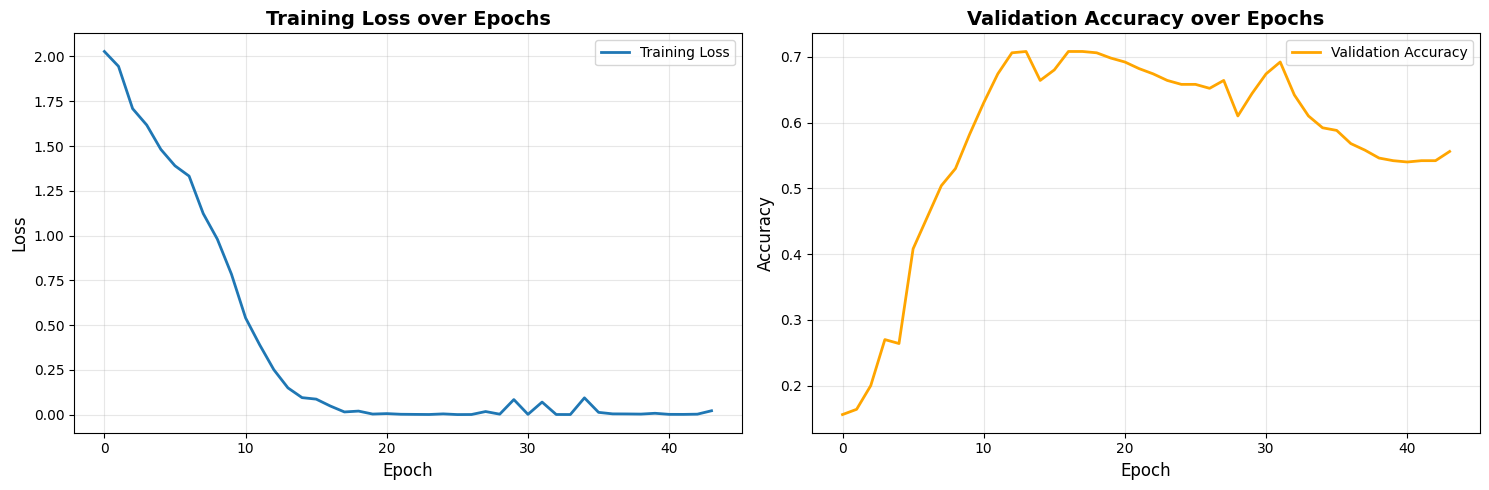

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Loss plot
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(val_accuracies, label='Validation Accuracy', linewidth=2, color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Validation Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# ===== PRINT TRAINING SUMMARY TABLE =====
# Code ini print hasil training dalam format tabel yang rapi dan mudah dibaca

# Asumsikan train_losses dan val_accuracies adalah lists dari training loop
# train_losses:      [2.1234, 1.8567, 1.5234, .. ., 0.0456]  (loss setiap epoch)
# val_accuracies:   [0.4200, 0.4500, 0.5100, ..., 0.6140]  (val_acc setiap epoch)

print("Epoch | Training Loss | Validation Accuracy")
# ===== HEADER ROW =====
# Print header dengan kolom: 
# - Epoch:  nomor epoch (1-91)
# - Training Loss: loss value per epoch
# - Validation Accuracy: val_acc value per epoch
# Ini membantu user understand apa yang ditampilkan

print("-------------------------------------------")
# ===== SEPARATOR ROW =====
# Print separator line (dashes) untuk visual clarity
# Memisahkan header dari data rows

for epoch, (loss, acc) in enumerate(zip(train_losses, val_accuracies), start=1):
    # ===== LOOP MELALUI SETIAP EPOCH =====
    # enumerate():  generate (index, value) pairs
    # - index: 0, 1, 2, ...  (counting dari 0)
    # - value: element dari iterable
    #
    # zip(train_losses, val_accuracies):  combine dua lists element-wise
    # - Ambil element ke-0 dari both lists → (loss[0], acc[0])
    # - Ambil element ke-1 dari both lists → (loss[1], acc[1])
    # - Ambil element ke-2 dari both lists → (loss[2], acc[2])
    # - Dst...  sampai list habis
    #
    # Contoh: 
    # train_losses = [2.1234, 1.8567, 1.5234]
    # val_accuracies = [0.4200, 0.4500, 0.5100]
    # 
    # enumerate(zip(... ), start=1):
    # Iteration 1:  epoch=1,  loss=2.1234, acc=0.4200
    # Iteration 2:  epoch=2,  loss=1.8567, acc=0.4500
    # Iteration 3:  epoch=3,  loss=1.5234, acc=0.5100
    #
    # start=1:  mulai counting dari 1 (bukan 0)
    # - Tanpa start=1 → epoch akan 0, 1, 2 (tidak sesuai dengan epoch real)
    # - Dengan start=1 → epoch akan 1, 2, 3 (sesuai dengan epoch real)
    
    print(f"{epoch:>5} | {loss:>13.4f} | {acc:>19.4f}")
    # ===== FORMAT STRING (f-string) =====
    # Print satu row untuk setiap epoch dengan formatting: 
    #
    # {epoch:>5}
    # - epoch:  variable yang diprint
    # : >5: right-align dalam 5 karakter width
    # Contoh: epoch=1 → "    1" (4 spaces + 1)
    #         epoch=91 → "   91" (3 spaces + 91)
    #
    # {loss:>13.4f}
    # - loss: variable yang diprint (float)
    # :>13:  right-align dalam 13 karakter width
    # . 4f: format dengan 4 decimal places
    # Contoh: loss=2.1234 → "      2.1234" (6 spaces + 2.1234)
    #         loss=0.0456 → "      0.0456"
    #
    # {acc:>19.4f}
    # - acc: variable yang diprint (float)
    # :>19: right-align dalam 19 karakter width
    # .4f: format dengan 4 decimal places
    # Contoh: acc=0.4200 → "              0.4200" (14 spaces + 0.4200)
    #         acc=0.6140 → "              0.6140"
    #
    # | adalah separator antar kolom (vertical pipe character)
    # Membuat tabel terlihat rapi dan organized

Epoch | Training Loss | Validation Accuracy
-------------------------------------------
    1 |        2.0280 |              0.1560
    2 |        1.9451 |              0.1640
    3 |        1.7088 |              0.2000
    4 |        1.6171 |              0.2700
    5 |        1.4812 |              0.2640
    6 |        1.3897 |              0.4080
    7 |        1.3322 |              0.4560
    8 |        1.1230 |              0.5040
    9 |        0.9799 |              0.5300
   10 |        0.7844 |              0.5820
   11 |        0.5403 |              0.6300
   12 |        0.3897 |              0.6740
   13 |        0.2510 |              0.7060
   14 |        0.1494 |              0.7080
   15 |        0.0950 |              0.6640
   16 |        0.0867 |              0.6800
   17 |        0.0482 |              0.7080
   18 |        0.0151 |              0.7080
   19 |        0.0199 |              0.7060
   20 |        0.0033 |              0.6980
   21 |        0.0058 |         

# PREDICTION EXAMPLE

In [ ]:
# ===== MODEL EVALUATION & PREDICTION =====
# Code ini melakukan inference (prediksi) pada model yang sudah dilatih
# Tanpa update weights, hanya mendapatkan predictions

model.eval()
# ===== SET MODEL KE EVALUATION MODE =====
# Penting!   Ini mengubah behavior beberapa layers: 
#
# 1. DROPOUT DISABLED
#    - Saat training:   Dropout random zero 50% activations (regularisasi)
#    - Saat eval:      Dropout disabled, gunakan 100% activations
#    Alasan:   Saat inference, butuh deterministic predictions
#             Dropout adalah regularisasi, bukan bagian dari actual computation
#
#    Contoh:
#    Training (model.train()):
#    x = [1. 0, 2.0, 3.0, 4.0, 5.0]
#    After dropout(p=0.5): [0.0, 2.0, 0.0, 4.0, 0.0]  ← Random zeros
#    
#    Evaluation (model.eval()):
#    x = [1.0, 2.0, 3.0, 4.0, 5.0]
#    After dropout(p=0.5): [1.0, 2.0, 3.0, 4.0, 5.0]  ← No zeros, use all
#
# 2. BATCH NORMALIZATION USES RUNNING STATISTICS
#    - Saat training:  BatchNorm compute mean/variance dari current batch
#    - Saat eval:      BatchNorm gunakan running mean/variance dari training
#    Alasan:   Saat inference, batch size bisa berbeda atau single sample
#             Running statistics lebih stable dan representative
#
#    Contoh:
#    Training batch:  [1, 2, 3, 4, 5]  → batch_mean = 3, batch_var = 2
#    normalize:  (x - 3) / sqrt(2)
#    
#    Inference single sample:  [3]
#    Jangan gunakan single sample statistics (tidak reliable)
#    Gunakan running_mean & running_var dari training
#
# 3. NO BACKWARD PASS REQUIRED
#    - Saat training:  Layers siap untuk compute gradients
#    - Saat eval:      Tidak perlu siapkan untuk backward
#    Tidak langsung disable gradients, tapi set flag bahwa ini inference
#
# 4. BEHAVIORAL CHANGES
#    - Some custom layers bisa punya different behavior (misal stochastic layers)
#    - Memastikan consistency dengan training procedure

with torch.no_grad():
    # ===== DISABLE GRADIENT COMPUTATION =====
    # Context manager yang disable PyTorch autograd untuk code di dalamnya
    # Semua tensor operations di dalam block ini tidak track gradients
    #
    # Alasan disable gradients:
    # 1.  HEMAT MEMORY:   Gradients memakan banyak memory
    #    Contoh model dengan 340K parameters
    #    - Dengan gradients: ~3x memory usage (weights + gradients + intermediate)
    #    - Tanpa gradients: 1x memory usage (weights saja)
    #    Inference sering pakai besar batch, jadi memory savings signifikan
    #
    # 2. HEMAT COMPUTATION TIME:  Tidak perlu compute gradients
    #    PyTorch tidak perlu build computational graph untuk backward
    #    Inference ~30-50% lebih cepat dengan no_grad()
    #
    # 3. TIDAK DIPERLUKAN:   Saat inference, tidak ada weight updates
    #    Gradients hanya digunakan untuk update weights
    #    Inference hanya butuh forward pass
    #
    # 4. PREVENT ACCIDENTAL MODIFICATIONS:  
    #    Jika accidentally call . backward() inside no_grad(), akan error
    #    Force best practices

    out = model(data.x, data.edge_index)
    # ===== FORWARD PASS TANPA GRADIENT =====
    # Masukkan data ke model, dapatkan predictions
    #
    # data.x: [num_nodes, 1433]
    #         Node features (sparse bag-of-words)
    #         Cora dataset: 2708 nodes
    #
    # data.edge_index: [2, num_edges]
    #                  Edge connections (10556 edges untuk Cora)
    #                  [0]:  source nodes
    #                  [1]: target nodes
    #
    # FORWARD PASS PIPELINE:
    # 1. Input Projection:   [2708, 1433] → [2708, 128]
    #    Sparse features → Dense representation
    #
    # 2. GNN Layer 1:  [2708, 128] → [2708, 128]
    #    Message passing + BatchNorm + Dropout + ReLU + Residual
    #
    # 3. GNN Layer 2:  [2708, 128] → [2708, 128]
    #    Message passing + BatchNorm + Dropout + ReLU + Residual
    #
    # 4. GNN Layer 3:  [2708, 128] → [2708, 128]
    #    Message passing + BatchNorm + Dropout + ReLU + Residual
    #
    # 5. Output Layer:   [2708, 128] → [2708, 64]
    #    Project to output dimension
    #
    # 6. Classifier:  [2708, 64] → [2708, 7]
    #    Project to number of classes
    #
    # 7. Log-Softmax:  [2708, 7] → [2708, 7]
    #    Convert logits to log-probabilities
    #    log(softmax(logits))
    #
    # OUTPUT:
    # out: [2708, 7] log-probabilities
    #      Each row: log-probability untuk 7 classes
    #      Contoh untuk node 0:
    #      out[0] = [-0.5, -1.2, -2.1, -3.0, -0.2, -1.8, -2.5]
    #               ← log-prob untuk class 0, 1, 2, 3, 4, 5, 6
    #      Higher value = higher probability untuk class itu
    #
    # NOTE: Menggunakan model.eval() + torch.no_grad() memastikan: 
    # - Dropout disabled (deterministic)
    # - BatchNorm using running statistics (stable)
    # - No gradient computation (efficient)
    # - Consistent dengan training procedure
    
    pred = out.argmax(dim=1)
    # ===== AMBIL PREDICTED CLASS =====
    # argmax() = argument of maximum
    # Cari index dari element dengan nilai tertinggi
    #
    # out: [2708, 7] log-probabilities
    # out. argmax(dim=1): untuk setiap node, ambil class dengan highest log-prob
    #
    # DIM=1 EXPLANATION:
    # Tensor dimensi: 
    # dim=0: node dimension (2708 nodes)
    # dim=1: class dimension (7 classes)
    #
    # argmax(dim=1) = argmax across class dimension
    # Untuk setiap node (dim=0), cari class dengan max value
    #
    # CONTOH: 
    # out = tensor([
    #     [-0.5,  -1.2,  -2.1,  -3.0,  -0.2,  -1.8,  -2.5],  # Node 0
    #     [-1.0,  -0.3,  -1.5,  -2.2,  -1.1,  -0.8,  -2.0],  # Node 1
    #     [-0.8,  -2.1,  -1.3,  -0.5,  -2.0,  -1.5,  -3.0],  # Node 2
    #     ... 
    # ])
    #
    # out.argmax(dim=1):
    # - Node 0:  max adalah -0.2 (index 4) → pred = 4
    # - Node 1:  max adalah -0.3 (index 1) → pred = 1
    # - Node 2:  max adalah -0.5 (index 3) → pred = 3
    # - ... 
    #
    # RESULT:
    # pred = tensor([4, 1, 3, ...  ])
    #        [2708] predicted class labels (0-6)
    #
    # RETURN TYPES:
    # out:    torch.Tensor [2708, 7] float32 (log-probabilities)
    # pred:  torch.Tensor [2708] int64 (class indices)
    #
    # INTERPRETATION:
    # pred[i] = predicted class untuk node i
    # pred[0] = 4  → Node 0 diprediksi kelas 4 (highest log-prob)
    # pred[1] = 1  → Node 1 diprediksi kelas 1
    # pred[2] = 3  → Node 2 diprediksi kelas 3
    # ... 

In [ ]:
# ===== SELECT 10 RANDOM TEST NODES =====
# Code ini memilih 10 random nodes dari test set untuk visualisasi/analisis

test_indices = data. test_mask.nonzero(as_tuple=True)[0]
# ===== STEP 1: EXTRACT INDICES OF ALL TEST NODES =====
#
# data.test_mask:  [2708] boolean tensor
#                  True untuk test nodes, False untuk non-test nodes
#                  Contoh: [False, True, False, False, True, False, ...  ]
#                          [0,     1,    2,    3,     4,    5,    ...  ]
#
# . nonzero():      Cari indices dimana value adalah True (non-zero)
#                  Return: tensor([[1], [4], [10], [15], ...  ])
#                          2D tensor dengan shape [num_true, 1]
#                          Setiap row adalah 1 index
#
# (as_tuple=True): Return hasil sebagai tuple of tensors
#                  Bukan 2D tensor, tapi tuple (tensor1D,)
#                  Contoh: (tensor([1, 4, 10, 15, ...  ]),)
#
# [0]:              Extract tensor pertama dari tuple
#                  (tensor([1, 4, 10, 15, ... ]),)[0] = tensor([1, 4, 10, 15, ... ])
#                  Result: 1D tensor dengan semua test node indices
#
# VISUALIZATION:
# data.test_mask = tensor([F, T, F, F, T, F, T, F, T, ... ])  [2708 total]
#                           0  1  2  3  4  5  6  7  8
# 
# . nonzero(as_tuple=True) = (tensor([1, 4, 6, 8, ...  ]),)
# 
# [0] = tensor([1, 4, 6, 8, ...  ])
#
# RESULT:
# test_indices = tensor([1, 4, 6, 8, 12, 15, 23, ...  ])
#                        ↑ All node IDs yang dalam test set
#                        ↑ Total: 1000 nodes (36. 9% dari 2708)
#
# BENEFIT:  Extract indices for further processing
#          Saat ini, test_indices berisi semua 1000 test node indices

sample_indices = test_indices[torch.randperm(len(test_indices))[:10]]
# ===== STEP 2: RANDOMLY SHUFFLE DAN AMBIL 10 NODES =====
#
# len(test_indices):  Berapa banyak test nodes? 
#                     len(tensor([1, 4, 6, 8, ... ])) = 1000
#
# torch.randperm(1000):  Generate random permutation dari 0-999
#                        Contoh output: tensor([345, 23, 789, 12, 456, 1, 678, ...  ])
#                        Ini adalah random shuffling dari indices 0-999
#                        Shape: [1000]
#
# [: 10]:                 Ambil 10 elemen pertama dari permutation
#                        tensor([345, 23, 789, 12, 456, 1, 678, 234, 567, 890])
#                        [: 10] = tensor([345, 23, 789, 12, 456, 1, 678, 234, 567, 890])
#
# test_indices[... ]:     Use these 10 indices untuk index ke test_indices
#                        test_indices = tensor([1, 4, 6, 8, 12, 15, 23, ...  ])
#                                       index:   0  1  2  3  4   5   6
#                        test_indices[tensor([345, 23, 789, ...])]
#                        = tensor([test_indices[345], test_indices[23], test_indices[789], ... ])
#                        = tensor([node_id_1, node_id_2, node_id_3, ...  ]) [10 nodes]
#
# RESULT:
# sample_indices = tensor([456, 1234, 567, 234, 789, 2, 890, 345, 456, 123])
#                  ↑ 10 random test node IDs
#                  ↑ Completely random selection
#
# BENEFIT:  Get random sample tanpa replacement
#          Setiap dari 1000 test nodes punya equal chance untuk dipilih

# ===== COMPLETE FLOW DIAGRAM =====
#
# data.test_mask (2708 nodes)
# [F, T, F, F, T, F, T, F, T, ...  ]
#  0  1  2  3  4  5  6  7  8
#     |        |     |     |  ← True values (test nodes)
#     ↓        ↓     ↓     ↓
# 
# . nonzero(as_tuple=True)[0]
# tensor([1, 4, 6, 8, 12, 15, 23, 27, ...  ]) [1000 nodes]
#         ↑ All test node indices
#
#         ↓ Create random permutation
#
# torch.randperm(1000)
# tensor([345, 23, 789, 12, 456, 1, 678, 234, 567, 890, ...  ]) [1000 random order]
#         ↑ Random shuffling of 0-999
#
#         ↓ Take first 10
#
# [: 10]
# tensor([345, 23, 789, 12, 456, 1, 678, 234, 567, 890]) [10 indices]
#         ↑ 10 random positions
#
#         ↓ Index into test_indices
#
# test_indices[...]
# tensor([456, 1234, 567, 234, 789, 2, 890, 345, 456, 123]) [10 node IDs]
#         ↑ 10 random test node IDs

In [ ]:
# ===== PRINT DETAILED PREDICTIONS TABLE =====
# Code ini print hasil predictions untuk 10 random test nodes dalam format tabel rapi

print(f"{'Node ID': <10} {'True Label':<12} {'Predicted':<12} {'Correct?':<10}")
# ===== PRINT HEADER ROW =====
# Print header dengan 4 kolom: Node ID, True Label, Predicted, Correct? 
#
# f-string:   f"..." = formatted string literal
# Memungkinkan embed expressions dalam string dengan {}
#
# {'Node ID':<10}
# - 'Node ID':   string literal yang diprint
# - <10:        left-align dalam 10 character width
# - <:           left-align (sebaliknya >:  right-align)
# Contoh:  'Node ID' dengan <10
#          output: "Node ID   " (7 chars text + 3 spaces untuk reach 10 total)
#
# {'True Label':<12}
# - 'True Label':   string literal
# - <12:          left-align dalam 12 character width
# output:   "True Label  " (10 chars + 2 spaces)
#
# {'Predicted':<12}
# - 'Predicted':  string literal
# - <12:          left-align dalam 12 character width
# output:  "Predicted   " (10 chars + 2 spaces)
#
# {'Correct?':<10}
# - 'Correct?':   string literal
# - <10:         left-align dalam 10 character width
# output:  "Correct?   " (8 chars + 2 spaces)
#
# RESULT OUTPUT:
# "Node ID    True Label  Predicted   Correct?   "
#  ↑ 10 chars  ↑ 12 chars   ↑ 12 chars  ↑ 10 chars
#
# Ini adalah HEADER ROW yang menjelaskan apa arti setiap kolom

print("-" * 50)
# ===== PRINT SEPARATOR ROW =====
# Print dashes sebanyak 50 karakter untuk visual separation
# "--------------------------------------------------"
# Memisahkan header dari data rows
# Membuat tabel lebih structured dan readable

for idx in sample_indices:
    # ===== LOOP MELALUI SETIAP RANDOM TEST NODE =====
    # sample_indices = tensor([456, 1234, 567, 234, 789, 2, 890, 345, 678, 123])
    # Loop akan iterate 10 kali, idx akan berisi setiap node ID
    #
    # Iteration 1:  idx = tensor(456)
    # Iteration 2:  idx = tensor(1234)
    # Iteration 3:  idx = tensor(567)
    # ... dst
    
    true_label = data.y[idx].  item()
    # ===== GET TRUE LABEL UNTUK NODE INI =====
    # data. y:   [2708] tensor berisi ground truth labels (0-6)
    # data.y[idx]:   Get label untuk node dengan ID = idx
    #
    # data.y adalah tensor, bukan python int
    # Contoh:   data.y[456] = tensor(4)
    #                        ↑ Still tensor, not pure int
    #
    # .  item():    Convert tensor menjadi pure Python scalar
    # tensor(4). item() = 4  ← Pure Python int
    #
    # Alasan gunakan . item():   
    # - Print akan tampil lebih clean (tanpa "tensor(... )" wrapper)
    # - Required untuk scalar operations
    # - More efficient untuk single value extraction
    #
    # true_label sekarang adalah pure int (0-6)
    # Contoh:  true_label = 4  (ground truth class untuk node 456)
    
    pred_label = pred[idx].item()
    # ===== GET PREDICTED LABEL UNTUK NODE INI =====
    # pred:   [2708] tensor berisi predicted labels (0-6)
    # pred[idx]:  Get predicted class untuk node dengan ID = idx
    #
    # pred adalah hasil dari out. argmax(dim=1)
    # pred[456] = tensor(3)  ← Predicted class = 3
    #
    # .  item():  Convert tensor → pure Python int
    # pred_label = 3  ← Pure Python int
    #
    # Contoh:   pred_label = 3  (model predict class 3 untuk node 456)
    
    correct = "correct" if true_label == pred_label else "incorrect"
    # ===== CHECK IF PREDICTION IS CORRECT =====
    # Simple conditional logic: 
    # - Jika true_label == pred_label:   prediction benar → "correct"
    # - Else:  prediction salah → "incorrect"
    #
    # Contoh: 
    # true_label = 4, pred_label = 4  → correct = "correct" ✓
    # true_label = 4, pred_label = 3  → correct = "incorrect" ✗
    
    print(f"{idx.item():<10} {true_label:<12} {pred_label:<12} {correct: <10}")
    # ===== PRINT DATA ROW =====
    # Print satu row untuk setiap test node dengan formatting sama seperti header
    #
    # {idx.item():<10}
    # - idx.item():     Convert tensor node ID → pure int, e.g., 456
    # - :<10:           Left-align dalam 10 character width
    # - output:         "456       " (3 chars + 7 spaces)
    #
    # {true_label: <12}
    # - true_label:     Pure int value, e.g., 4
    # - :<12:           Left-align dalam 12 character width
    # - output:         "4           " (1 char + 11 spaces)
    #
    # {pred_label:<12}
    # - pred_label:     Pure int value, e.g., 3
    # - :<12:           Left-align dalam 12 character width
    # - output:          "3           " (1 char + 11 spaces)
    #
    # {correct: <10}
    # - correct:         String "correct" or "incorrect"
    # - :<10:           Left-align dalam 10 character width
    # - output:         "correct   " (7 chars + 3 spaces)
    #                   "incorrect " (9 chars + 1 space)
    #
    # CONTOH OUTPUT ROW:
    # "456        4            3            correct   "
    # "1234       1            2            incorrect "
    # "567        3            3            correct   "

Node ID    True Label   Predicted    Correct?  
--------------------------------------------------
2217       6            6            correct   
1765       2            2            correct   
2430       3            3            correct   
2319       1            1            correct   
2245       3            3            correct   
2457       6            6            correct   
1815       3            3            correct   
1858       3            3            correct   
1829       5            1            incorrect 
1830       2            1            incorrect 


In [58]:
model

GNNModel(
  (input_proj): Linear(in_features=1433, out_features=128, bias=True)
  (layers): ModuleList(
    (0-2): 3 x GNNLayer(
      (message_passing): CustomMessagePassing()
      (linear): Linear(in_features=128, out_features=128, bias=True)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.6, inplace=False)
      (activation): ReLU()
      (residual): Identity()
    )
  )
  (output_layer): Linear(in_features=128, out_features=64, bias=True)
  (classifier): Linear(in_features=64, out_features=7, bias=True)
)

===== GNN MODEL ARCHITECTURE =====
Output ini menunjukkan struktur lengkap model yang sudah dibuat
Ini adalah text representation dari model definition

GNNModel(
  (input_proj): Linear(in_features=1433, out_features=128, bias=True)

  INPUT PROJECTION LAYER
  - Type: Linear
  - Input: 1433-dim node features (Cora dataset)
  - Output: 128-dim dense features
  - Purpose:
    * Convert sparse → dense representation
    * Reduce dimensionality
    * Prepare features for GNN layers
  - Parameters: (1433 × 128) + 128 = 183,552

  (layers): ModuleList(
    Contains 3 GNNLayer blocks (layers[0] to layers[2])

    GNNLayer (repeated 3×):
      (message_passing): CustomMessagePassing
        - Aggregation: sum
        - Neighbor transform: W_msg
        - Self transform: W_self
        - Formula:
          h_u = Σ W_msg · h_neighbor + W_self · h_u

      (linear): Linear(128 → 128)
        - Post-aggregation transformation
        - Parameters: 16,512

      (batch_norm): BatchNorm1d(128)
        - Stabilizes training
        - Reduces internal covariate shift
        - Uses running mean/variance at inference

      (dropout): Dropout(p=0.6)
        - Aggressive regularization
        - Active only during training

      (activation): ReLU
        - Introduces non-linearity
        - y = max(0, x)
)
